# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2021-11-07 09:00:24--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2021-11-07 09:00:24--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2021-11-07 09:00:24 ERROR 404: Not Found.

--2021-11-07 09:00:24--  https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xzm5f5vrx6jwqui/training.csv [following]
--2021-11-07 09:00:24--  https://www.drop

In [2]:
# loading data
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

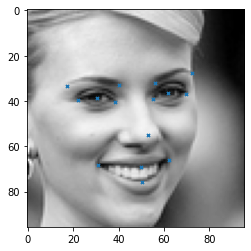

In [3]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [4]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [5]:
from scipy.ndimage.filters import gaussian_filter

numImg = x_train.shape[0]
numExt = 6
new_X = np.ndarray(shape=(x_train.shape[0]*numExt, x_train.shape[1], x_train.shape[2]))
new_y = np.ndarray(shape=(y_train.shape[0]*numExt, y_train.shape[1]))
columns = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y", "left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x", "left_eye_outer_corner_y", "right_eye_inner_corner_x", "right_eye_inner_corner_y", "right_eye_outer_corner_x", "right_eye_outer_corner_y", "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y", "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y", "nose_tip_x", "nose_tip_y", "mouth_left_corner_x", "mouth_left_corner_y", "mouth_right_corner_x", "mouth_right_corner_y", "mouth_center_top_lip_x", "mouth_center_top_lip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]   

flipX = np.array([(-1)**(i+1) for i in range(30)])
flipY = np.array([(-1)**(i) for i in range(30)])

# dataset augmentation
for i in range(numImg):
  img = np.squeeze(x_train[i, :, :])
  tgt = y_train[i, :]

  #original
  new_X[i, :, :] = img
  new_y[i, :] = tgt

  #blurred
  new_X[i+numImg, :] = gaussian_filter(img, sigma=2)
  new_y[i+numImg, :] = tgt

  #brighter
  new_X[i+numImg*2, :, :] = (img + 1)/2
  new_y[i+numImg*2, :] = tgt

  #darker
  new_X[i+numImg*3, :, :] = img/2
  new_y[i+numImg*3, :] = tgt

  #flipped
  new_X[i+numImg*4, :, :] = np.fliplr(img)
  auxY = np.multiply(flipX, tgt)
  # flip labels
  left_ix = [i for (i, el) in enumerate(columns) if 'left' in el]
  right_ix = [i for (i, el) in enumerate(columns) if 'right' in el]
  auxY[left_ix], auxY[right_ix] = auxY[right_ix], auxY[left_ix]
  new_y[i+numImg*4, :] = auxY

  # data dropout (images are 96x96, so a 10% noise is around 900 pixels)
  num_replaced = 900
  indices_x = np.random.randint(0, img.shape[0], num_replaced)
  indices_y = np.random.randint(0, img.shape[1], num_replaced)
  auxX = np.copy(img)
  auxX[indices_x, indices_y] = 0
  new_X[i+numImg*5, :, :] = auxX
  new_y[i+numImg*5, :] = tgt



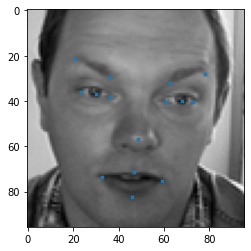

In [6]:
# checking data augmentation (original)
plot_sample(new_X[12], new_y[12])

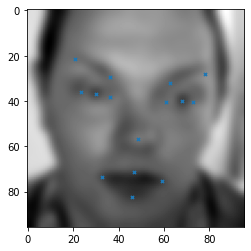

In [7]:
# blurred
plot_sample(new_X[12 + numImg], new_y[12 + numImg])

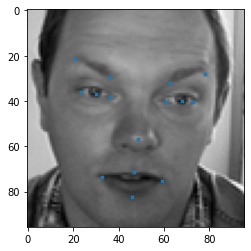

In [8]:
# brighter (plot normalizes the ranges so the image looks the same, but the value of the numbers has changed)
plot_sample(new_X[12 + numImg*2], new_y[12 + numImg*2])

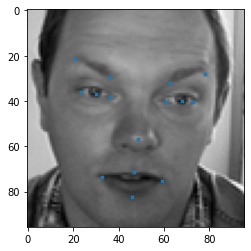

In [9]:
# darker (plot normalizes the ranges so the image looks the same, but the value of the numbers has changed)
plot_sample(new_X[12 + numImg*3], new_y[12 + numImg*3])

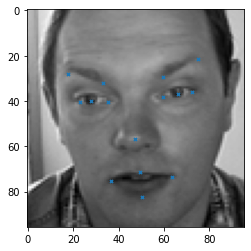

In [10]:
# mirrored
plot_sample(new_X[12 + numImg*4], new_y[12 + numImg*4])

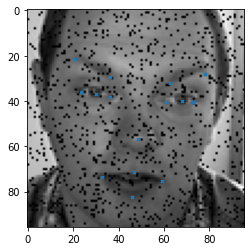

In [11]:
# flipped upside down
plot_sample(new_X[12 + numImg*5], new_y[12 + numImg*5])

In [ ]:
# Repeat samples in order to augment the training set even more
new_X = np.concatenate((new_X, new_X, new_X), axis=0)
new_y = np.concatenate((new_y, new_y, new_y), axis=0)
print(new_X.shape)

In [16]:
new_X = np.expand_dims(new_X, -1)
print(new_X.shape)

(26964, 96, 96, 1)


In [30]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(90, activation="relu"),
        layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 16)        416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)       

In [31]:
batch_size = 16
epochs = 1000

from keras import backend as K
from keras.callbacks import EarlyStopping

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer='adam')

cb_list = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001, mode='auto')]
model.fit(new_X, new_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=cb_list)

Epoch 1/1000
1349/1349 [==============================] - 21s 15ms/step - loss: 0.0667 - val_loss: 0.0544
Epoch 2/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0423 - val_loss: 0.0332
Epoch 3/1000
1349/1349 [==============================] - 21s 16ms/step - loss: 0.0336 - val_loss: 0.0280
Epoch 4/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0306 - val_loss: 0.0254
Epoch 5/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0288 - val_loss: 0.0240
Epoch 6/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0278 - val_loss: 0.0242
Epoch 7/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0268 - val_loss: 0.0224
Epoch 8/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0262 - val_loss: 0.0210
Epoch 9/1000
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0256 - val_loss: 0.0214
Epoch 10/1000
1349/1349 [=====================

In [33]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.3687172


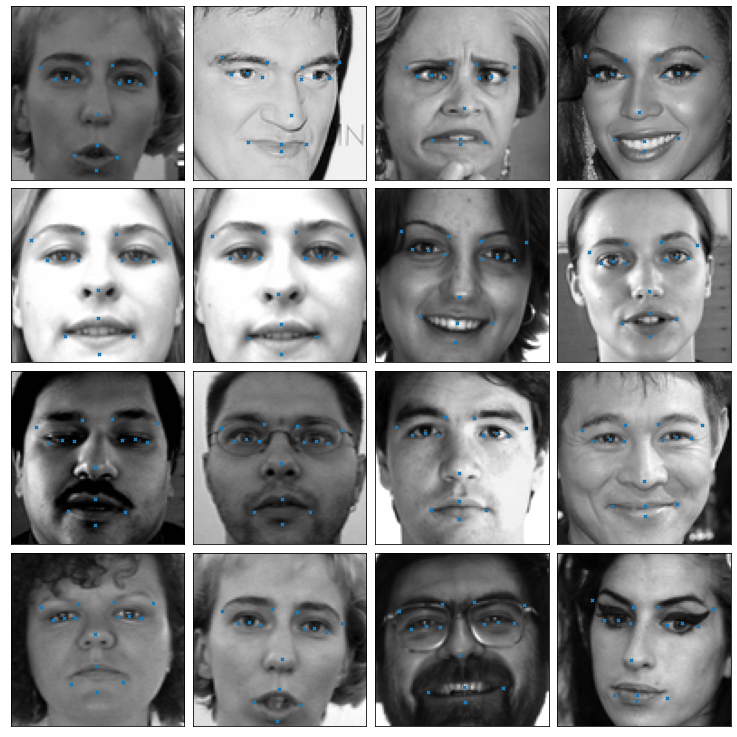

In [35]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

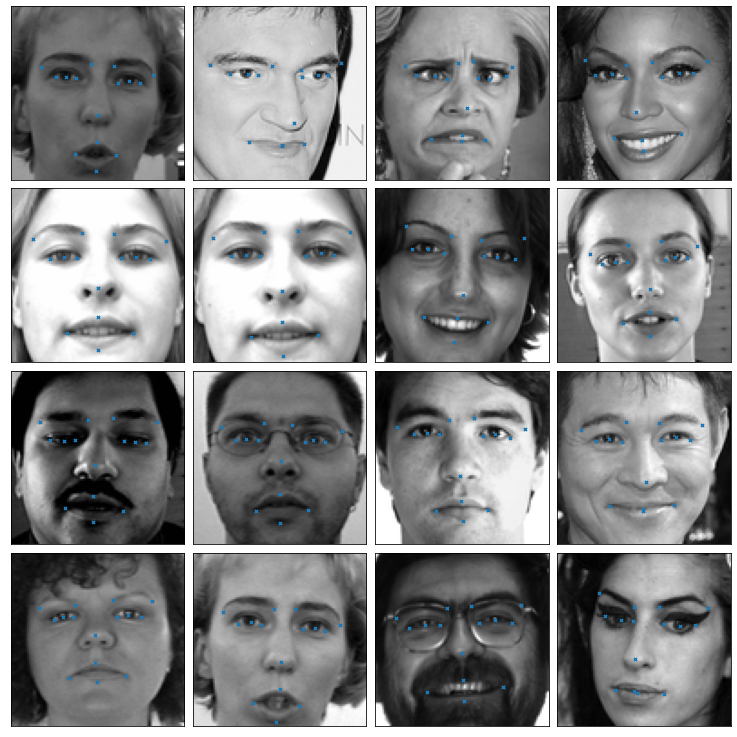

In [36]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.3687172

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: First of all, I tried to flip the images. However, I was forgetting to flip the labels too so the results were always worse, even with more complex model, as the data was corrupted. I decided to leave this strategy behind for a while.

Then I augmented the dataset in a way that I did not have to flip the labels: making the images blurry, brighter and darker. With the basic model, I got a 1.34 mean error. But then I realized I was cheating, as I was augmenting the whole dataset, instead of only augmenting the training set.

Augmenting only the dataset with no flipped images and with the basic model, would lead to a 1.89 mean error. Afterwards I finally found a way to flip the images and the labels correctly, so I added the flipped images to the dataset too.

At this point, I decided to change the model. A first attempt, increasing its depth and width to 4 layers of 2 cells got us a 1.58 mean error. Early stopping was implemented in order to being able to iterate as much as possible without worrying about it taking too long.

Adding Dropout layers in each level of our model led us to a relatively closer to 1.50 result.

Then I tried to check if other optimizers would lead to better results. SGD seems to work better at first, but in future experiments adam was the preferred setting by the experiments. 

At this point, no modification in the model was leading to better results, so I deduced I needed more data. So then I added dropout in the training data, setting 900 random points to 0. 

I tried to increase the batch size to make the model take shorter time to train. It did not have the effect I expected: it made the results worse. Consequently, I figured it out a lower batch size would be a good idea: batch size was set to 16.

After reading online that Input Batch Normalization and Global Max Pooling were very useful for this kind of problem, I added them to the model structure. Also, I was suggested to repeat samples in the training set in order to augment the dataset more. It had incredibly noticeable effects on the output, causing the mean error to come closer to 1.40.

Finally, I decided to simplify the model, getting rid of its width and internal dropout layers, obtaining the final structure that I am delivering. Lastly, changing the kernel size in the first layers had a positive impact on the outcome too. It is worth noting that I added an extra Dense layer at the end and added a droput layer between the two dense layers with a bigger size difference.

In [34]:
K.clear_session()
del model